<a href="https://colab.research.google.com/github/anmolchaure/climate_emulators/blob/main/Gan_new_running.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gpflow
!pip install utils
!pip install cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)

!pip install shapely --no-binary shapely
!pip install eofs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 37.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.5 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102745 sha256=b33e66b6b6cf69eb9410e50a2810404e1f300a13a93c902825d3d230be95a029
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
     

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [ ]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob



def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """

    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    X_all      = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"inputs_{file}.nc"))
        X_all.append(data)
        length_all.append(len(data.time))

    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

def prepare_predictand(data_sets,data_path,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    Y_all = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"outputs_{file}.nc"))
        Y_all.append(data)
        length_all.append(len(data.time))

    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))

    return Y, length_all


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()




# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):

    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)

    return yr, mean

In [ ]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')
test_path  = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')

make_dir(train_path)
make_dir(test_path)

In [ ]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

In [ ]:

X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

# Normalization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,X_test.shape)

(753, 2) (86, 2)


In [ ]:
var  = 'tas'
y_train = y_train_xr[var].data
y_test  = y_test_xr[var].data

mean = y_train.mean()
std  = y_train.std()

y_train = (y_train - mean)/std
y_test  = (y_test - mean)/std

y_train = np.expand_dims(y_train, -1).astype("float32")
y_test  = np.expand_dims(y_test, -1).astype("float32")

n_lat, n_lon = y_train.shape[1], y_train.shape[2]
print(y_train.shape,y_test.shape)
#OUTPUT_DIM =

(753, 96, 144, 1) (86, 96, 144, 1)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

discriminator_losses = []
generator_losses = []
k = 4

#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Generator model
def build_generator():
    model = keras.Sequential()
    model.add(layers.Dense(128, input_shape=(2,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(96 * 144, activation='LeakyReLU'))
    model.add(layers.Reshape((96, 144, 1)))
    #model.add(layers.BatchNormalization())
    return model

# Discriminator model
def build_discriminator():
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(96, 144, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.2))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Create the generator
generator = build_generator()

# Create the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.legacy.Adam(), metrics=['accuracy'])
discriminator.trainable = False

# Create the GAN model
gan_input = layers.Input(shape=(2,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.legacy.Adam())

# Training loop
batch_size = 32
epochs = 1000

for epoch in range(epochs):
    # Select a random batch of x_train
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = y_train[idx]

    # Generate a batch of fake images
    noise = np.random.normal(0, 0.001, (batch_size, 2))
    generated_images = generator.predict(noise)

    # Concatenate real and fake images
    combined_images = np.concatenate([generated_images, real_images])

    # Labels for generated and real data
    labels = np.concatenate([np.zeros((batch_size, 1)), np.ones((batch_size, 1))])

    # Train the discriminator
    discriminator.trainable = True
    discriminator_loss = discriminator.train_on_batch(combined_images, labels)

    # Train the generator
    noise = np.random.normal(0, 0.001, (batch_size, 2))
    discriminator.trainable = False
    gan_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))


    discriminator_losses.append(discriminator_loss[0])
    generator_losses.append(gan_loss)

    # Print the progress and loss
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Discriminator loss: {discriminator_loss[0]} | Generator loss: {gan_loss}")

# Generate some samples using the generator
num_samples = 10
noise = np.random.normal(0, 0.1, (num_samples, 2))
generated_samples = generator.predict(noise)

# Print the generated samples
#print("Generated samples:")
#print(generated_samples)


Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Epoch: 0 | Discriminator loss: 0.6151496171951294 | Generator loss: 0.8127657771110535
Epoch: 100 | Discriminator loss: 0.0 | Generator loss: 0.0020648050121963024
Epoch: 200 | Discriminator loss: 5.89383433454833e-28 | Generator loss: 0.0003432797675486654
Epoch: 300 | Discriminator loss: 0.0 | Generator loss: 0.0004856671148445457
Epoch: 400 | Discriminator loss: 0.34802985191345215 | Generator loss: 0.0
Epoch: 500 | Discriminator loss: 0.0 | Generator loss: 9.80428303591907e-05
Epoch: 600 | Discriminator loss: 0.0 | Generator loss: 0.0008090161136351526
Epoch: 700 | Discriminator loss: 1.0243075742593013e-27 | Generator loss: 0.000405286846216768
Epoch: 800 | Discriminator loss: 1.6610962205142085e-29 | Generator loss: 0.0004244683659635484
Epoch: 900 | Discriminator loss: 0.0 | Generator loss: 1.7736371797679927e-19


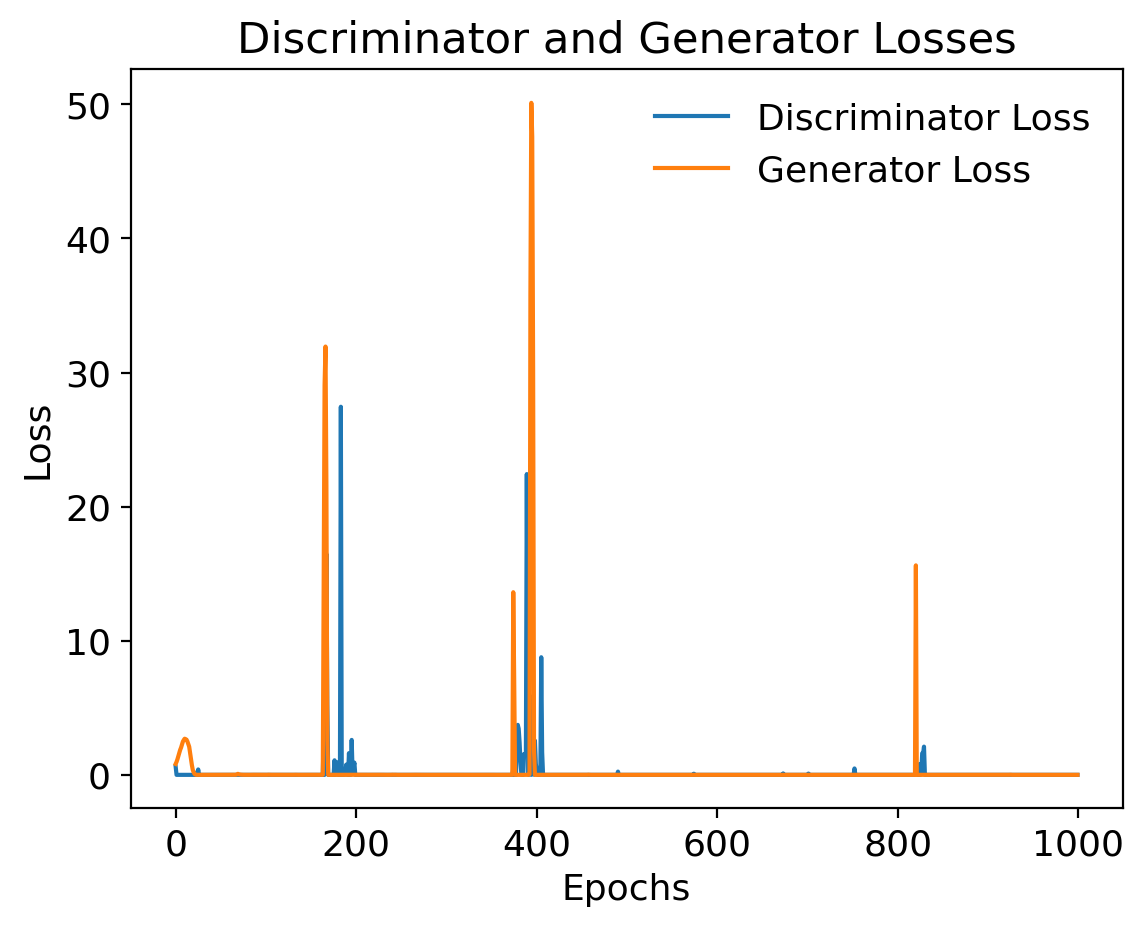

In [ ]:

# Plotting the losses
plt.plot(range(epochs), discriminator_losses, label='Discriminator Loss')
plt.plot(range(epochs), generator_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Losses')
plt.legend()
plt.show()

In [ ]:
# Generate latent vectors using the generator
z = np.random.normal(0, 1, (y_test.shape[0], 2))
generated_samples = generator.predict(z)

# Rescale the generated samples
generated_samples = generated_samples * std + mean

# Reshape and create an xarray dataset
generated_samples = generated_samples.reshape(y_test.shape[0], 96, 144)
generated_dataset = xr.Dataset(
    coords={'time': y_test_xr.time.values,
            'latitude': y_test_xr.latitude.values,
            'longitude': y_test_xr.longitude.values},
    data_vars=dict(tas=(['time', 'latitude', 'longitude'], generated_samples))
)

# Print the generated dataset
print(generated_dataset)
print()

<xarray.Dataset>
Dimensions:    (time: 86, latitude: 96, longitude: 144)
Coordinates:
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    tas        (time, latitude, longitude) float32 0.5353 1.775 ... 8.971 9.68



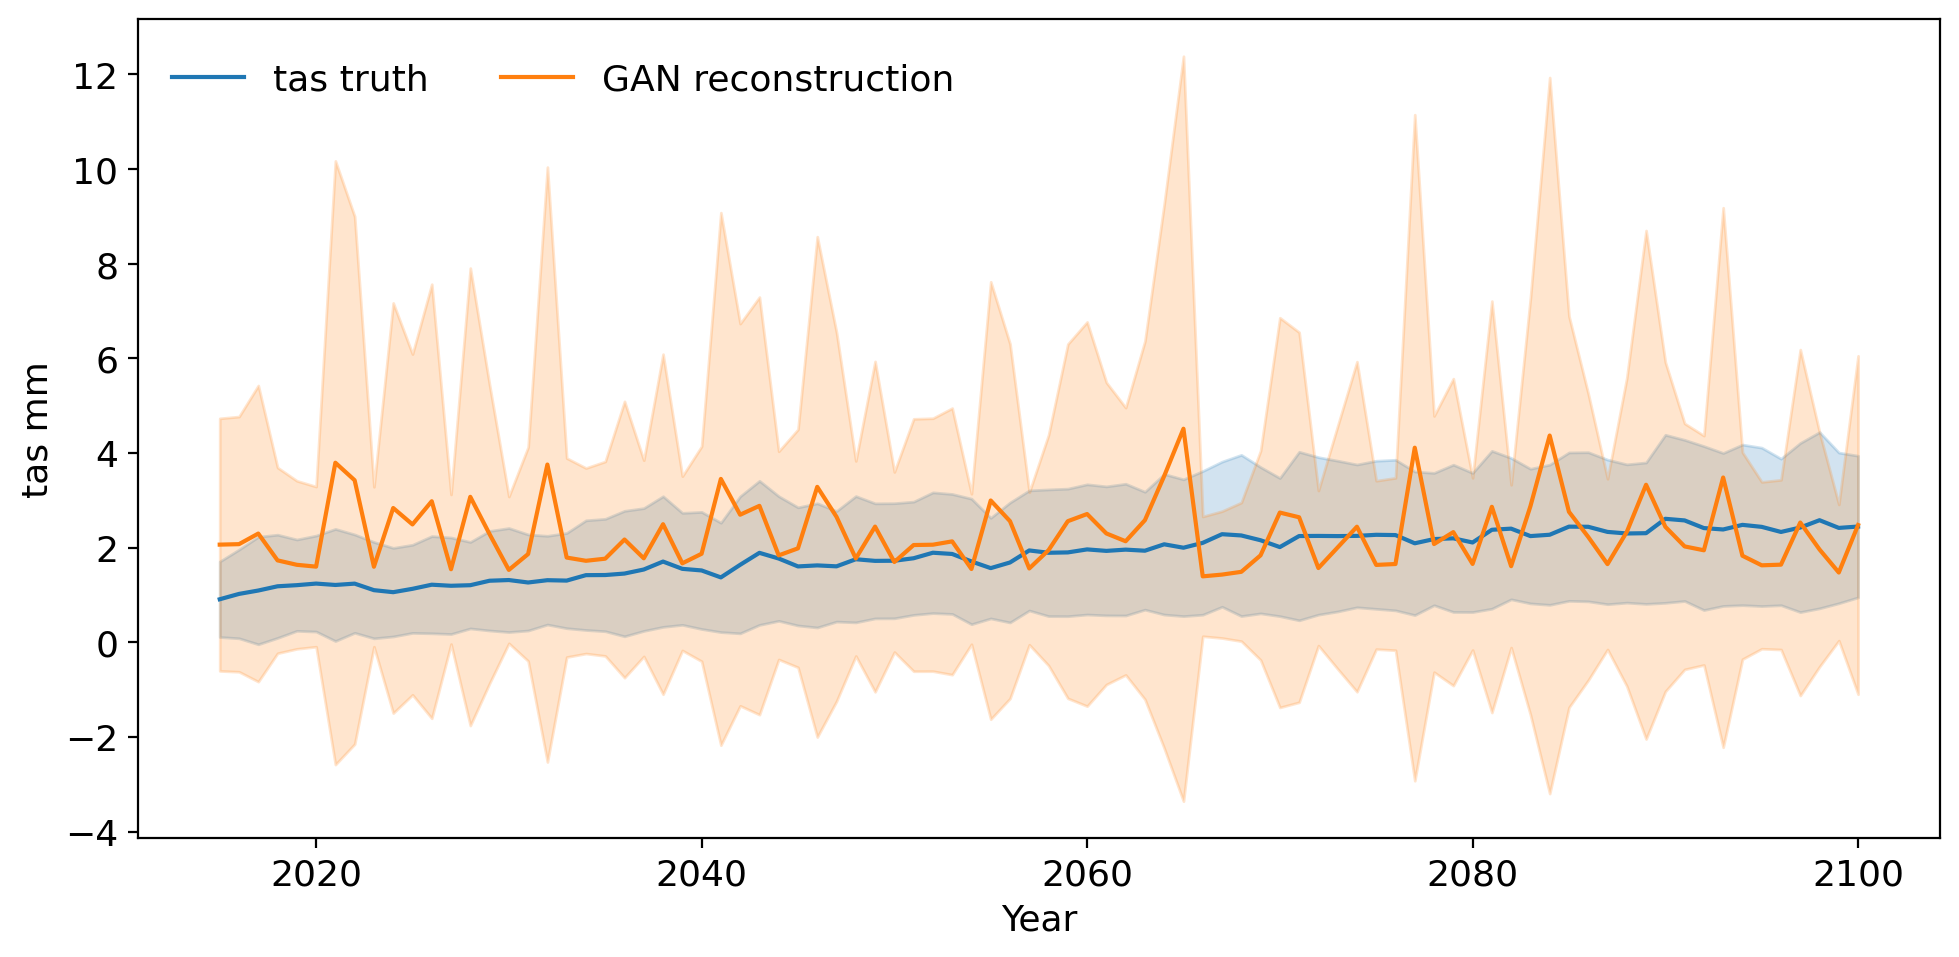

In [ ]:
import matplotlib.pyplot as plt

# Function to calculate mean and standard deviation
def mean_std_plot(data, color, label, ax):
    yr = data.coords['time'].values
    mean = data.mean(dim=('latitude', 'longitude')).values
    std = data.std(dim=('latitude', 'longitude')).values
    ax.plot(yr, mean, color=color, label=label)
    ax.fill_between(yr, mean - std, mean + std, color=color, alpha=0.2)
    return yr, mean

# Plotting the truth and GAN reconstruction
fig, ax = plt.subplots(figsize=(10, 5))

yr, mean_truth = mean_std_plot(y_test_xr['tas'], color='tab:blue', label='tas truth', ax=ax)
yr, mean_pre = mean_std_plot(generated_dataset['tas'], color='tab:orange', label='GAN reconstruction', ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('tas mm')

fig.legend(loc='upper left', bbox_to_anchor=(0.08, 0.95), ncol=2)

plt.tight_layout()
plt.show()


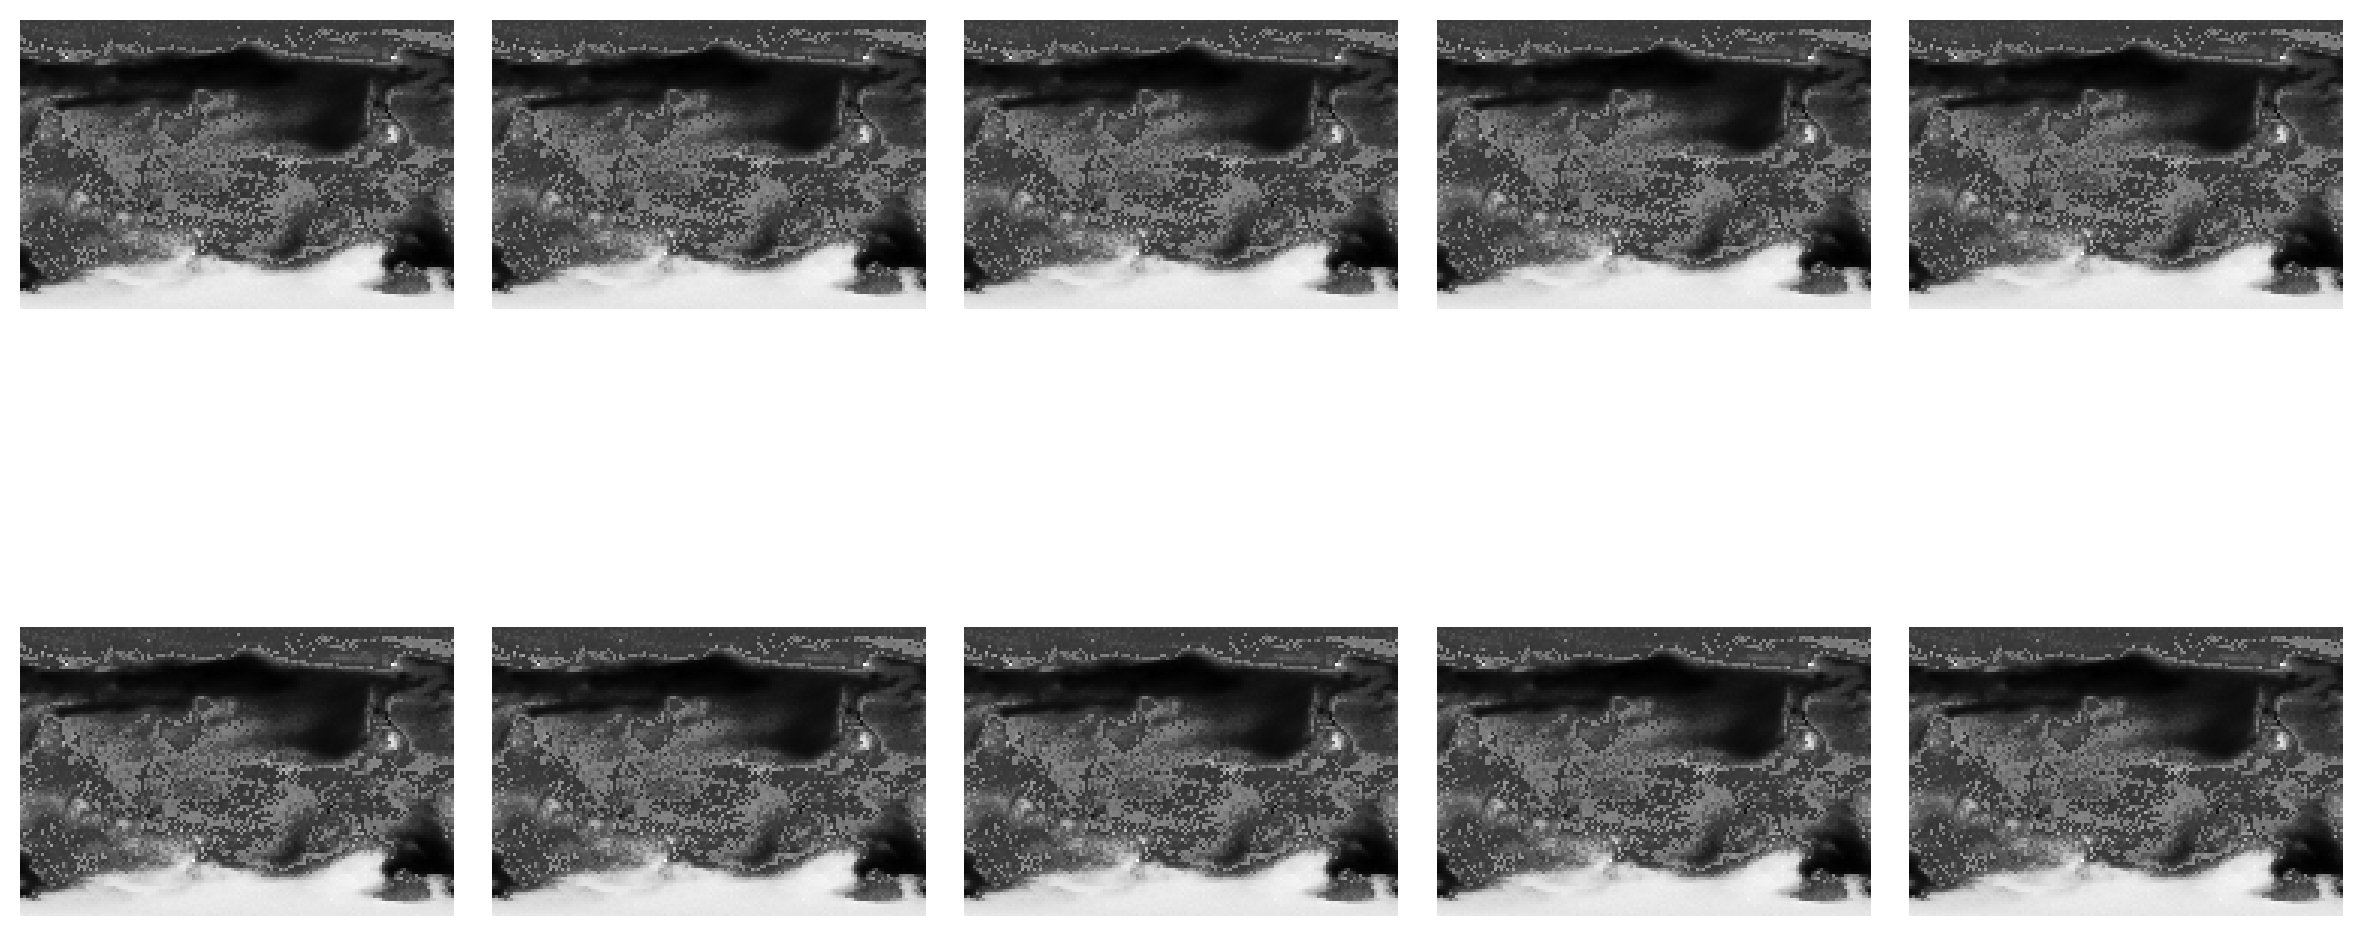

In [ ]:
import matplotlib.pyplot as plt

# Generate some samples using the generator
num_samples = 10
noise = np.random.normal(0, 0.001, (num_samples, 2))
generated_images = generator.predict(noise)

# Reshape the generated images if necessary
generated_images = generated_images.reshape((-1, 96, 144))

# Plot the generated images
fig, axes = plt.subplots(nrows=num_samples // 5, ncols=5, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.colors as colors

num_levels = 100  # Adjust the number of color levels as needed
cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', plt.cm.RdBu_r(np.linspace(0, 1, num_levels)))


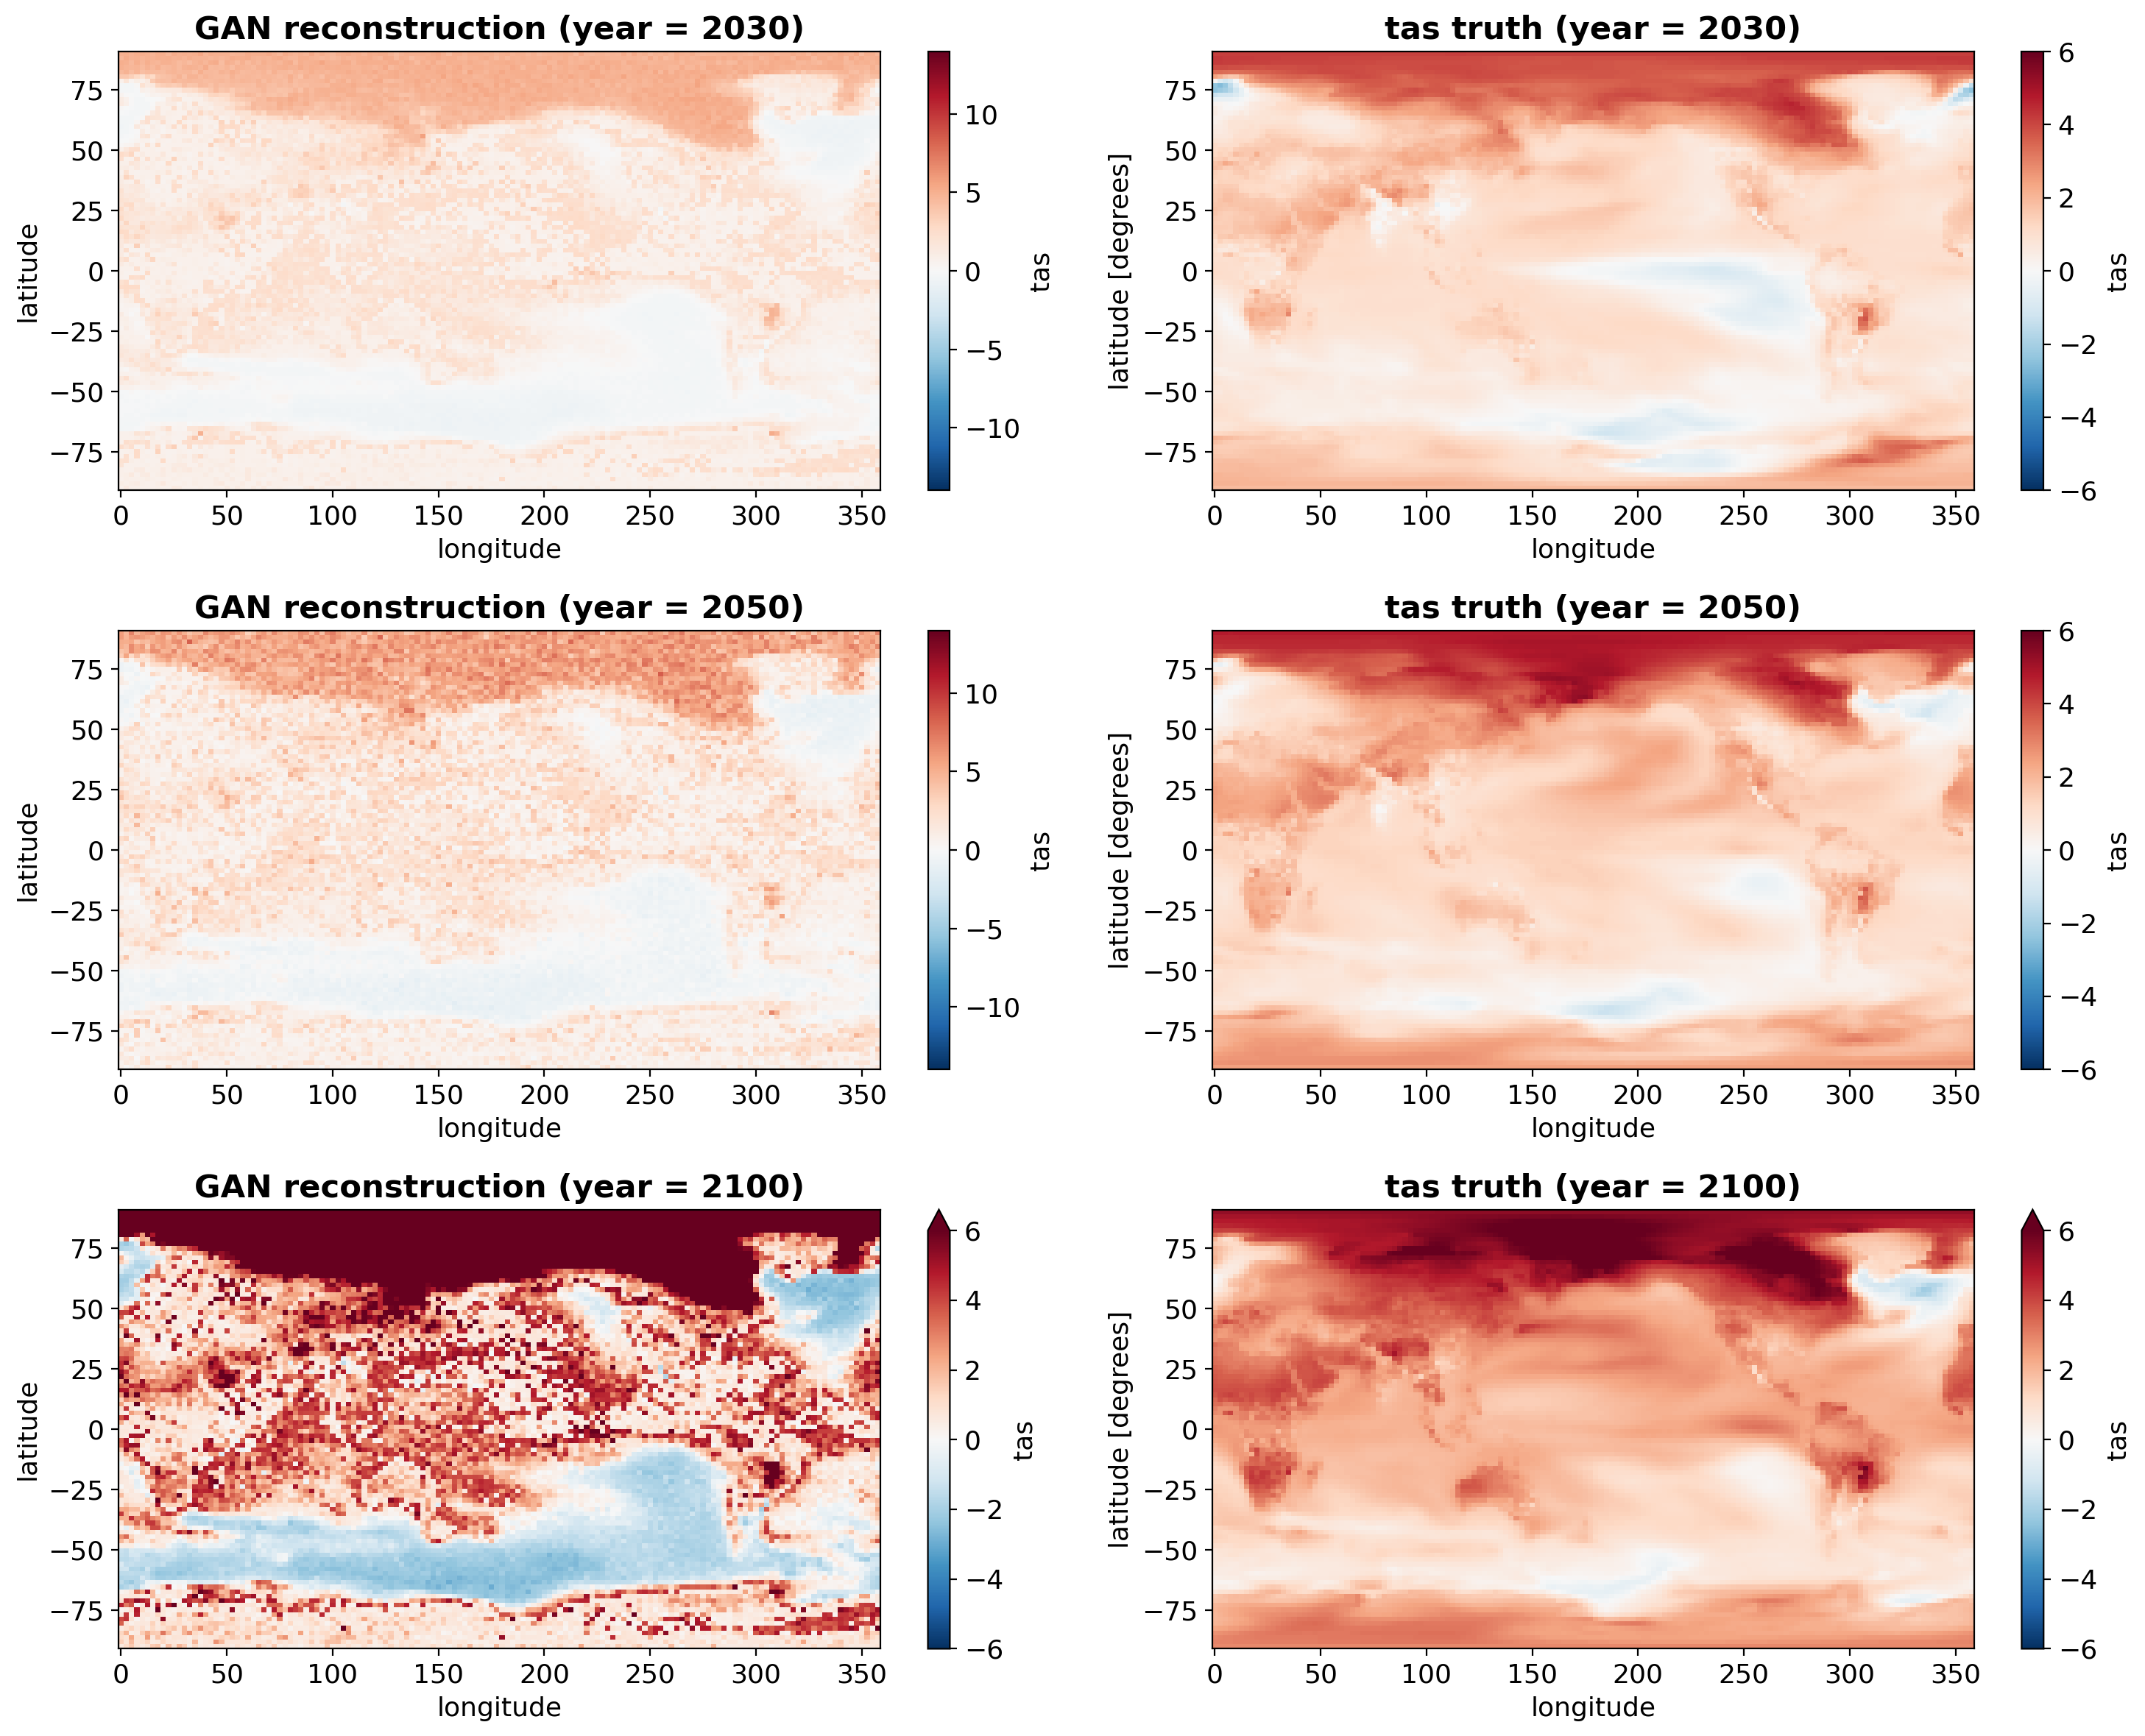

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(15, 12), ncols=2, nrows=3)

yrs = [2030, 2050, 2100]
vmin1, vmax1 = -14, 14
vmin,vmax = -6,6
cmap = 'RdBu_r'

generated_dataset.tas.sel(time=yrs[0]).plot(ax=axes[0, 0], vmin=vmin1, vmax=vmax1, cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0, 1], vmin=vmin, vmax=vmax, cmap=cmap)

generated_dataset.tas.sel(time=yrs[1]).plot(ax=axes[1, 0], vmin=vmin1, vmax=vmax1, cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1, 1], vmin=vmin, vmax=vmax, cmap=cmap)

generated_dataset.tas.sel(time=yrs[2]).plot(ax=axes[2, 0], vmin=vmin, vmax=vmax, cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2, 1], vmin=vmin, vmax=vmax, cmap=cmap)

for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.set_title(f'GAN reconstruction (year = {yrs[i//2]})', fontweight='bold')
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
y_test_pre = generated_dataset

[Text(0.5, 1.0, 'Difference')]

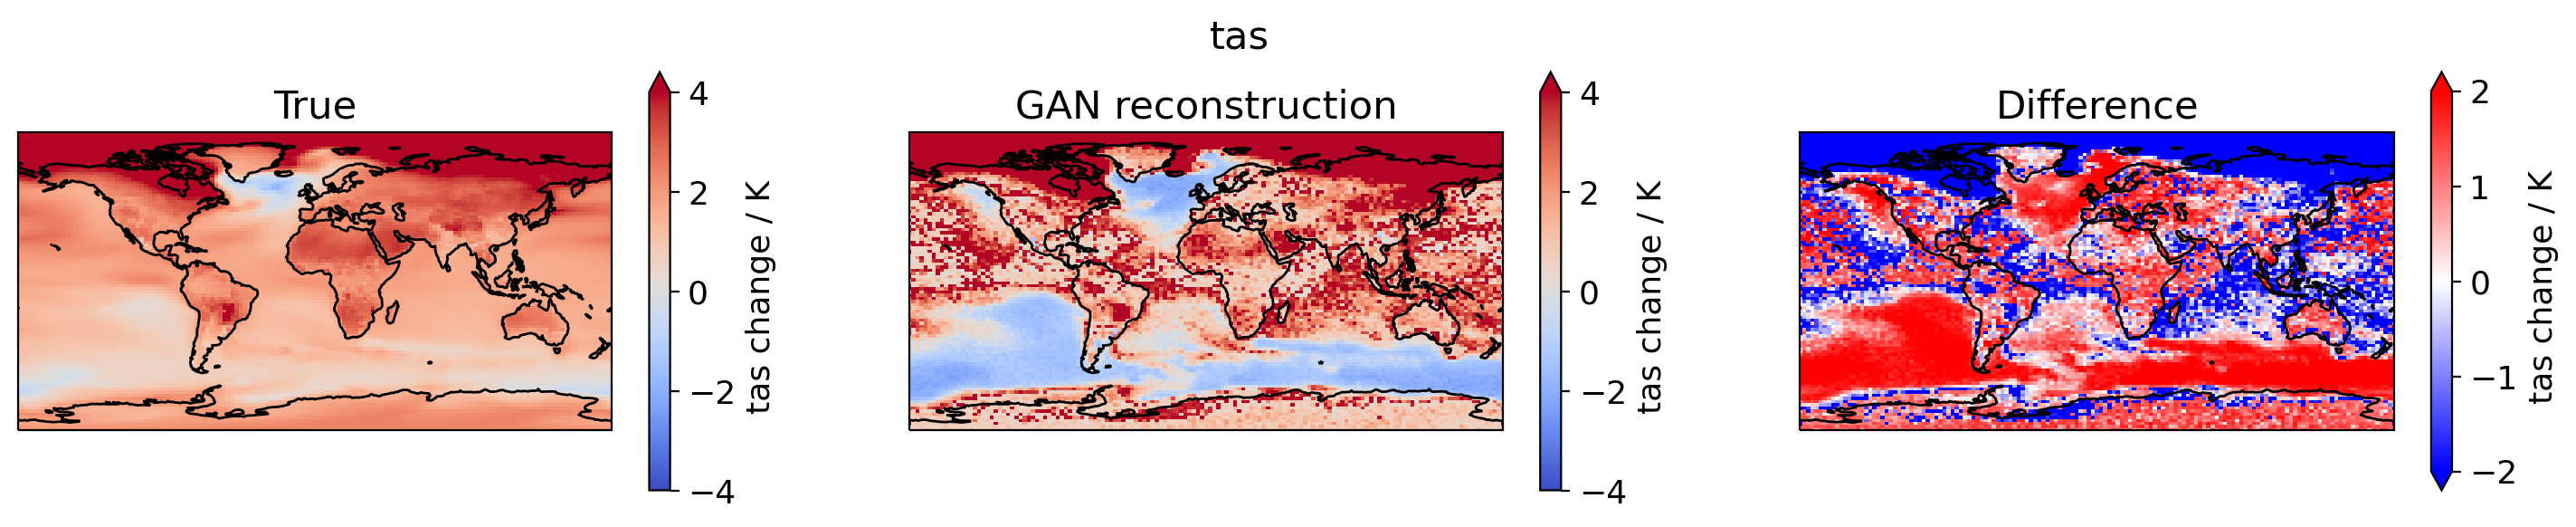

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## DTR
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('tas')

# Test
plt.subplot(131, projection=proj)
y_test_xr.tas.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"tas change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
y_test_pre.tas.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"tas change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GAN reconstruction')

# Difference
difference = y_test_xr.tas- y_test_pre.tas
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"tas change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [ ]:
mean_pre   = y_test_pre['tas']
y_test_pre_mean = mean_pre
y_test_pre_mean

<xarray.DataArray 'tas' (time: 86, latitude: 96, longitude: 144)>
array([[[ 5.35257936e-01,  1.77535367e+00,  1.33230543e+00, ...,
          1.70777166e+00,  5.34919679e-01,  5.21894634e-01],
        [ 1.07859659e+00,  1.15249896e+00,  7.74708331e-01, ...,
          1.72639549e+00,  1.51405489e+00,  7.28982091e-01],
        [ 4.32830960e-01,  1.24537468e+00,  5.88193893e-01, ...,
          1.45766139e+00,  7.44446397e-01,  4.20789123e-01],
        ...,
        [ 9.00264835e+00,  7.88164568e+00,  7.39646626e+00, ...,
          8.32874489e+00,  8.17206573e+00,  7.75417519e+00],
        [ 7.14740324e+00,  8.86929989e+00,  7.62153149e+00, ...,
          7.91051960e+00,  7.99327087e+00,  8.65026951e+00],
        [ 7.53176165e+00,  8.54945374e+00,  7.32226419e+00, ...,
          9.03829002e+00,  8.75494862e+00,  6.94563770e+00]],

       [[ 5.09705722e-01,  1.38568676e+00,  1.31898737e+00, ...,
          1.35442376e+00,  4.91792828e-01,  5.77379704e-01],
        [ 9.49153662e-01,  1.07957447e+00,  7.83291698e-01, ...,
          1.78143859e+00,  1.38946807e+00,  7.22800493e-01],
        [ 4.54884678e-01,  1.38846409e+00,  6.27470076e-01, ...,
          1.19272566e+00,  7.44956911e-01,  5.24468243e-01],
...
          4.51809359e+00,  4.48271990e+00,  4.47463655e+00],
        [ 4.60242844e+00,  4.50386000e+00,  4.59193230e+00, ...,
          4.56925344e+00,  4.62476301e+00,  4.55868387e+00],
        [ 4.71343517e+00,  4.41232443e+00,  4.82611656e+00, ...,
          4.42767811e+00,  4.38698912e+00,  4.60189867e+00]],

       [[ 5.77300131e-01,  1.13115275e+00,  1.56558251e+00, ...,
          6.54348433e-01,  6.19592428e-01,  7.56709456e-01],
        [ 1.47474265e+00,  8.33464026e-01,  1.91043997e+00, ...,
          1.13856566e+00,  7.14948058e-01,  6.13585830e-01],
        [ 1.11660469e+00,  8.25599253e-01,  2.36266375e+00, ...,
          1.92775249e+00,  1.25927985e+00,  8.45574141e-01],
        ...,
        [ 9.78326511e+00,  1.06007462e+01,  8.34812260e+00, ...,
          9.62415886e+00,  9.69740868e+00,  1.00562134e+01],
        [ 1.02410164e+01,  9.94565296e+00,  1.01790943e+01, ...,
          1.02336683e+01,  1.02151384e+01,  9.95574760e+00],
        [ 1.04438791e+01,  9.30591202e+00,  1.12836542e+01, ...,
          9.28346539e+00,  8.97115898e+00,  9.68046379e+00]]],
      dtype=float32)
Coordinates:
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5

In [ ]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(y_test_xr.tas[35], y_test_pre_mean[35])}")
print(f"RMSE at 2100: {get_rmse(y_test_xr.tas[85], y_test_pre_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(y_test_xr.tas[30:41], y_test_pre_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(y_test_xr.tas[75:], y_test_pre_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(y_test_xr.tas[35:], y_test_pre_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre_mean[-20:].mean(dim='time'))}")

RMSE at 2050: 1.0868393062575044
RMSE at 2100: 2.038089536956005
RMSE 2045-2055: 1.9058691808094699
RMSE 2090-2100: 1.71823604663728
RMSE 2050-2100: 1.9797561441717915
RMSE average last 20y: 1.8036756763558346
